## Projeto Final - Álgebra Linear e Aplicações (SME0142)
Projeto confeccionado por Natan Sanches (11795680) e Álvaro José Lopes (10873365).

- **Objetivo e tematização:** A temática utilizada para confecção do projeto foi a de construção de um _pipeline_ dentro do contexto de Processamento de Linguagem Natural. Um texto bruto pôde ser analisado, permitindo um estudo sobre cada palavra individualmente e sua relação com os contextos em sua vizinhança; técnica usualmente chamada de _Word Embedding_. A partir desse estudo, é possível vetorizar palavras e utilizar técnicas de Álgebra Linear para manipulá-las.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Leitura do texto central
Neste exemplo, utilizamos a romance Memórias Póstumas de Brás Cubas (clássico de Machado de Assis). O texto foi carregado a partir de um arquivo em disco, criando um _corpus_ (lista) de parágrafos disponíveis para manipulação.

In [2]:
inputFile = "data/memorias-postumas-bras-cubas.txt"
with open(inputFile) as f:
    corpus = f.readlines()
    
cleanedCorpus = []
fullSentence = ''
for sentence in corpus:
    if sentence == '\n':
        if 'CAPÍTULO' not in fullSentence:
            cleanedCorpus.append(fullSentence.replace('\n', ''))
        fullSentence = ''
    
    fullSentence += ' ' + sentence
corpusBrasCubas = cleanedCorpus

In [3]:
inputFile = "data/HN_posts_year_to_Sep_26_2016.csv"
df = pd.read_csv(inputFile)
corpusHN = df['title']

### 2. Pré-processamento do texto

Como em todo projeto envolvendo processamento de língua natural, é necessário que seja feito um pré-processamento que permite consistência na hora da análise textual. Dentre as técnicas de processamento realizadas, estão:

- Eliminação de conflitos case-sensitive, isto é, transformando todas as letras maiúsculas em minúsculas.
- Eliminação de caracteres não UTF-8, como uma maneira de preservar a consistência do texto.
- Eliminação de pontuações e objetos textuais de sinalização, uma vez que estes não serão importantes para a análise.
- Eliminação de _stop words_, ou palavras de parada (preposições, conjunções, etc), que não possuem contexto isolado.

In [4]:
punctranslation = str.maketrans(dict.fromkeys(punctuation))


# Realiza a tokenização e tratamento dos parágrafos do texto
def tokenize(corpus: str, language : str) -> list:
    setStopwords = set(stopwords.words(language))
    corpusTokenized = []
    for paragraph in corpus:
        paragraph = paragraph.lower()                                       # Tratamento de case-sensitive
        paragraph = paragraph.encode('utf8', 'ignore').decode()             # Eliminação de caracteres fora de UTF-8
        paragraph = paragraph.translate(punctranslation)                    # Eliminação de pontuações
        tokens = [token for token in paragraph.split()                      # Eliminação de stopwords
                  if token not in setStopwords and token != '']
        corpusTokenized.append(list(filter(None, tokens)))
        
    return corpusTokenized
    
corpusTokenizedBrasCubas = tokenize(corpusBrasCubas, 'portuguese')
corpusTokenizedHN = tokenize(corpusHN, 'english')

### 3. Contagem de unigramas do texto

Realiza, para cada parágrafo, a contagem de frequência de cada _token_ do texto.

In [5]:
def getUnigrams(corpusTokenized : str) -> Counter():
    unigrams = Counter()
    for paragraph in corpusTokenized:
        for token in paragraph:
            unigrams[token] += 1
            
    return unigrams

In [6]:
unigramsBrasCubas = getUnigrams(corpusTokenizedBrasCubas)
# Mapeamento de acesso (Token <-> Índice representativo)
token2indexBrasCubas = {token: index for index, token in enumerate(unigramsBrasCubas.keys())}
index2tokenBrasCubas = {index: token for token, index in token2indexBrasCubas.items()}

unigramsHN = getUnigrams(corpusTokenizedHN)
token2indexHN = {token: index for index, token in enumerate(unigramsHN.keys())}
index2tokenHN = {index: token for token, index in token2indexHN.items()}

### 4. Contagem de bigramas do texto

Realiza, para cada parágrafo, a contagem dos bigramas presentes. Um bigrama representa a ocorrência de um par palavra-contexto, de maneira com que o contexto esteja dentro da janela de contexto. Nesse caso, o _range_ da janela de contexto foi de três palavras (para frente e para trás).

In [7]:
def getSkipGrams(corpusTokenized : str, token2index : dict, gap = 3) -> Counter():
    # Contador de bigramas, considerando uma determinada janela de contexto (nesse caso, 'gap'
    # palavras antes e 'gap' palavras depois)
    skipgrams = Counter()

    for paragraph in corpusTokenized:
        tokens = [token2index[tok] for tok in paragraph]

        # Para cada palavra no parágrafo, realiza a análise dos contextos da vizinhança
        for indexWord, word in enumerate(paragraph):
            indexContextMin = max(0, indexWord - gap)
            indexContextMax = min(len(paragraph)-1, indexWord + gap)

            # Para cada contexto da vizinhança, crie um bigrama com a palavra central
            indexContexts = [index for index in range(indexContextMin, indexContextMax + 1) if index != indexWord]
            for indexContext in indexContexts:
                skipgram = (tokens[indexWord], tokens[indexContext])
                skipgrams[skipgram] += 1
    
    return skipgrams

In [8]:
skipgramsBrasCubas = getSkipGrams(corpusTokenizedBrasCubas, token2indexBrasCubas)
skipgramsHN = getSkipGrams(corpusTokenizedHN, token2indexHN)

In [9]:
def removeUnigrams(
    minCount : int, maxCount : int, token2index : dict, index2token : dict, 
    unigrams : Counter(), skipgrams : Counter()
):
    
    # Removendo tokens muito frequentes e muito raros
    updatedtoken2index = token2index.copy()
    updatedindex2token = index2token.copy()

    for token in list(unigrams.keys()):
        if unigrams[token] < minCount or unigrams[token] > maxCount:
            del unigrams[token]
            index = token2index[token]
            del updatedtoken2index[token]
            del updatedindex2token[index]
    
    for word, context in list(skipgrams.keys()):
        if index2token[word] not in unigrams or index2token[context] not in unigrams:
            del skipgrams[(word, context)]
    
    return updatedindex2token, updatedtoken2index

In [10]:
# minCount, maxCount = (1 / 1000) * len(corpusBrasCubas), (1 / 10) * len(corpusBrasCubas)
# index2tokenBrasCubas, token2indexBrasCubas = removeUnigrams(
#     minCount, maxCount, token2indexBrasCubas, index2tokenBrasCubas, unigramsBrasCubas, skipgramsBrasCubas)

minCount, maxCount = (1 / 1000) * len(corpusHN), (1 / 50) * len(corpusHN)
index2tokenHN, token2indexHN = removeUnigrams(
    minCount, maxCount, token2indexHN, index2tokenHN, unigramsHN, skipgramsHN)

### 5. Criação da matriz de frequência termo-a-termo

Criação da matriz que relaciona dois _tokens_ (um bigrama) ao seu devido número de ocorrências.

In [11]:
def getCountMatrix(skipgrams : Counter()) -> sparse.csr_matrix:
    # Mapeamento das entradas da matriz esparça de frequência entre os bigramas do texto
    rowsMatrix = []
    columnsMatrix = []
    dataMatrix = []

    for (token1, token2), skipgramCount in skipgrams.items():
        rowsMatrix.append(token1)
        columnsMatrix.append(token2)
        dataMatrix.append(skipgramCount)

    return sparse.csr_matrix((dataMatrix, (rowsMatrix, columnsMatrix)))

In [12]:
wwMatrixBrasCubas = getCountMatrix(skipgramsBrasCubas)
wwMatrixHN = getCountMatrix(skipgramsHN)

### 6. Criação da matriz PPMI

O PMI (Pointwise Mutual Information) é uma métrica que relaciona a probabilidade de ocorrência de uma palavra em conjunto com certo contexto, quando comparada à ocorrência de ambos isolados. Dessa forma, para uma palavra $w$ relacionada a um contexto $c$, o PMI dentre elas é dado pela relação

$$pmi(w, c) = \log{\left(\dfrac{P(w, c)}{P(w)P(c)}\right)}$$

onde $P(w, c)$ representa a probabilidade de ocorrência de determinada palavra em determinado contexto, $P(w)$ representa a probabilidade de ocorrência de determinada palavra no texto e $P(c)$ representa a probabilidade de ocorrência de determinado contexto no texto. Munidos dessa informação, podemos eliminar a possibilidade de $pmi(w, c)$ assumir valores negativos utilizando sua variação denominada de PPMI (Positive Pointwise Mutual Information), dada por

$$ppmi(w,c) = \textrm{max}(0,\ pmi(w, c)).$$

A matriz PPMI $[M]_{n \times n}$ é uma matriz quadrada que relaciona uma palavra $w$ e um contexto $c$ ao seu valor PPMI, de tal forma que $M(w, c) = ppmi(w, c)$.

In [13]:
def getPPMImatrix(wwMatrix : sparse.csr_matrix, skipgrams : Counter()) -> sparse.csr_matrix:
    # Número total de bigramas presente na matriz de frequência
    numSkipgrams = wwMatrix.sum()

    # Mapeamento das entradas da matriz PPMI
    rowsIndex = []
    columnsIndex = []
    ppmiData = []

    # Vetor de frequência total de cada palavra em todos os possíveis contextos
    sumWords = np.array(wwMatrix.sum(axis=0)).flatten()

    # Vetor de frequência total de cada contexto para todas as possíveis palavras
    sumContexts = np.array(wwMatrix.sum(axis=1)).flatten()

    for (tokenWord, tokenContext), skipgramCount in skipgrams.items():

        # Frequência de determinada palavra em determinado contexto
        # [#(w,c)]
        freqWordContext = skipgramCount

        # Frequência de determinada palavra em todos os contextos possíveis
        # [#(w)]
        freqWord = sumContexts[tokenWord]

        # Frequência de determinado contexto para todas as palavras possíveis
        # [#(c)]
        freqContext = sumWords[tokenContext]

        # Probabilidade de ocorrência de determinada palavra em determinado contexto
        # [P(w,c)]
        probWordContext = freqWordContext / numSkipgrams

        # Probabilidade de ocorrência de determinada palavra individualmente
        # [P(w)]
        probWord = freqWord / numSkipgrams

        # Probabilidade de ocorrência de determinado contexto individualmente
        # [P(c)]
        probContext = freqContext / numSkipgrams

        # Cálculo PPMI (Positive Pointwise Mutual Information)
        # [PPMI = max(0, log( P(w,c)/(P(w)P(c)) ))]
        PPMI = max(np.log2(probWordContext / (probWord * probContext)), 0)

        rowsIndex.append(tokenWord)
        columnsIndex.append(tokenContext)
        ppmiData.append(PPMI)

    return sparse.csr_matrix((ppmiData, (rowsIndex, columnsIndex)))

In [14]:
ppmiMatrixBrasCubas = getPPMImatrix(wwMatrixBrasCubas, skipgramsBrasCubas)
ppmiMatrixHN = getPPMImatrix(wwMatrixHN, skipgramsHN)

### 7. Fatoração matricial usando SVD (Singular Value Decomposition)

A Decomposição por Valor Singular (SVD) é uma maneira possível de fatorarmos a matriz esparça de PPMI, de maneira que possamos deixá-la mais densa. Uma matriz $[M]_{m \times n}$ pode ser fatorada da forma

$$M = U \Sigma V^*$$

onde $[U]_{m \times m}$ é uma matriz unitária, $[\Sigma]_{m \times n}$ é uma matriz retangular diagonal e $[V^*]_{n \times n}$ é uma matriz unitária (dita conjugada transposta de $V$). As entradas diagonais de $\Sigma$ são os ditos valores singulares de $M$, enquanto o espaço-coluna de $U$ e $V$ contém os ditos vetores singulares à esquerda e à direita de $M$, respectivamente. 

In [15]:
from scipy.sparse.linalg import svds as SVD

def getWordVecs(ppmiMatrix : sparse.csr_matrix, embeddingSize = 50) -> np.ndarray:
    # Dimensão proposta da matriz de valores singulares produzida pelo SVD
    # [Hiperparâmetro]
    embeddingSize = 50

    U, D, V = SVD(ppmiMatrix, embeddingSize)

    # Normalização das matrizes de vetores singulares produzidas pelo SVD
    Unorm = U / np.sqrt(np.sum(U*U, axis=1, keepdims=True))
    Vnorm = V / np.sqrt(np.sum(V*V, axis=1, keepdims=True))

    return Unorm

In [16]:
wordVecsBrasCubas = getWordVecs(ppmiMatrixBrasCubas)
wordVecsHN = getWordVecs(ppmiMatrixHN)

### 8. Visualização de palavras similares por similaridade por cosseno

A similaridade por cosseno é uma métrica de similaridade entre vetores que consiste em comparar o ângulo entre eles. Para dois vetores $u$ e $v$, a similaridade por cosseno pode ser descrita pela relação

$$cos(\theta) = \dfrac{u \cdot v}{||u||\ ||v||} = \dfrac{\sum_{i=1}^n u_i v_i}{\sqrt{\sum_{i=1}^n u_i^{\ 2}}\ \sqrt{\sum_{i=1}^n v_i^{\ 2}}}$$

de tal forma que $\theta$ descreve o ângulo entre esses vetores e $u \cdot v$ é o produto escalar entre eles. Essa métrica de similiadade pode ser utilizada, em palavras vetorizadas, para medir o índice de relação entre uma palavra e um contexto.


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

# Cálculo dos 10 contextos mais similares a dada palavra utilizando a matriz de Word Embedding
def wordsSimilarity(word : str, matrix : np.ndarray, token2index : dict, index2token : dict, n : int):
    wordIndex = token2index[word]

    # Resgate do vetor representante de determinada palavra
    if isinstance(matrix, sparse.csr_matrix):
        wordVec = matrix.getrow(wordIndex)
    else:
        wordVec = matrix[wordIndex:wordIndex+1, :]
        
    print(wordVec.shape)

    # Cálculo da similidade (similaridade de vetores por cosseno)
    similarity = cosine_similarity(matrix, wordVec).flatten()
    sortedIndexes = np.argsort(-similarity)

    # Retorno dos n contextos mais similares a dada palavra
    similarityContextScores = [(index2token[sortedIndex], similarity[sortedIndex]) 
                                for sortedIndex in sortedIndexes[:n+1] 
                                if index2token[sortedIndex] != word]

    return similarityContextScores

def wordSimilarityReport(
    word : str, matrix : np.ndarray, unigrams : Counter(), token2index : dict, index2token : dict, n=5
):
    print(f'\'{word}\'\t Frequência total: {unigrams[word]}', end='\n\t')

    similarityContextScores = wordsSimilarity(word, matrix, token2index, index2token, n)
    for context, similarity in similarityContextScores:
        print(f'(\'{context}\', {similarity})', end='\t')

def getExamplesSimilarity(
    examples : list, wordVecs : np.ndarray, unigrams : Counter(), token2index : dict, index2token : dict
):
    for word in examples:
        wordSimilarityReport(word, wordVecs, unigrams, token2index, index2token)
        print('\n'+'---'*20)
    

In [76]:
examples = ['defunto', 'autor', 'brás', 'coimbra', 'flagelos', 'alegria', 'shakespeare', 'homem', 'luxo',
    'filósofo', 'festa', 'olhos', 'guerra', 'ensino', 'borba', 'autor', 'leitor']
getExamplesSimilarity(
    examples, wordVecsBrasCubas, unigramsBrasCubas, token2indexBrasCubas, index2tokenBrasCubas)

'defunto'	 Frequência total: 6
	(1, 50)
('campa', 0.6746168068468186)	('autor', 0.6151385979010779)	('lorpa', 0.6095057883956855)	('propriamente', 0.5407653053434001)	('consular', 0.5360443966781012)	
------------------------------------------------------------
'autor'	 Frequência total: 6
	(1, 50)
('conhece', 0.789200094114813)	('campa', 0.7156197176322138)	('prejuízo', 0.7086163766598012)	('bibliômano', 0.6943374900763779)	('dr', 0.6887019978540381)	
------------------------------------------------------------
'brás'	 Frequência total: 30
	(1, 50)
('cubas', 0.9769073553454316)	('adotei', 0.9669953696673037)	('palerma', 0.9634145212019593)	('tejadilho', 0.9586951536105883)	('mouriscas', 0.9562553264272469)	
------------------------------------------------------------
'coimbra'	 Frequência total: 5
	(1, 50)
('primou', 0.8059552908746227)	('matérias', 0.7878930538847297)	('esperavame', 0.7732384578162014)	('estudou', 0.7216044372472821)	('cursar', 0.7033942649042229)	
------------------

In [19]:
examples = ['facebook', 'twitter', 'instagram', 'messenger', 'hack', 'security', 
          'deep', 'encryption', 'command', 'venture' , 'bitcoin', 'github', 'opensource',
          'linux', 'microsoft', 'tensorflow', 'whatsapp', 'kernel', 'bill', 'elon', 'silicon', 'course',
           'startup', 'blog']
getExamplesSimilarity(examples, wordVecsHN, unigramsHN, token2indexHN, index2tokenHN)

'facebook'	 Frequência total: 2853
	('messenger', 0.7481192811378354)	('snapchat', 0.6929861114171034)	('twitter', 0.6820202347044038)	('instagram', 0.6459948113726345)	('whatsapp', 0.6265137742726805)	
------------------------------------------------------------
'twitter'	 Frequência total: 1641
	('facebook', 0.6820202347044035)	('linkedin', 0.6148361240418154)	('instagram', 0.59142725448504)	('yahoo', 0.5233872340348628)	('snapchat', 0.4805978668475303)	
------------------------------------------------------------
'instagram'	 Frequência total: 391
	('facebook', 0.6459948113726345)	('twitter', 0.5914272544850401)	('users', 0.5464186689508803)	('snapchat', 0.5379379942689114)	('whatsapp', 0.5371825681171153)	
------------------------------------------------------------
'messenger'	 Frequência total: 374
	('chat', 0.8039849360455708)	('bot', 0.7811380387402994)	('messaging', 0.7494799883230409)	('facebook', 0.7481192811378354)	('bots', 0.7132258704674771)	
-----------------------------

### 9. Visualizando as palavras através de um ScatterPlot interativo

Para que seja possível plotar as palavras é preciso realizar uma redução de dimensionalidade nos dados, uma vez que a dimensão dos vetores de *embedding* é maior do que dois.

Serão testados dois métodos de redução de dimensionalidade:
* PCA (*Principal Component Analysis*): Promove uma transformação linear ortogonal nos dados, projetando-os em uma nova base que preserva o máximo possível da variância dos dados. Dessa forma, ao longo da primeira coordenada (primeira componente) tem-se a maior variância e, analogamente, ao longo da segunda coordenada (segunda componente) tem-se a segunda maior variância.

* t-SNE (*T-distributed Stochastic Neighbor Embedding*): Método estatístico que estabelece uma distribuição de probabilidade para todos os pares de pontos de tal forma que para pontos similares (pontos próximos a partir de uma dada métrica) serão atribuídas uma alta probabilidade, enquanto para pontos dissimilares (pontos distantes) serão atribuídas uma baixa probabilidade. A métrica escolhida será o cosseno.

Após a redução de dimensionalidade será possível plotar as palavras em um espaço euclideano de duas dimensões, em que cada ponto representa uma palavra.

In [20]:
def createWordVecsDataFrame(reducedWordVecs, token2index):
    # Criando um dicionário para cada palavra e seu respectivo vetor após redução de dimensionalidade
    dictReducedWordVecs = {}
    for word, index in token2index.items():
        dictReducedWordVecs[word] = reducedWordVecs[index]

    # Instanciando o dataframe a partir do dicionario criado acima
    dfWordVecs = pd.DataFrame.from_dict(
        data = dictReducedWordVecs,
        orient = 'index',
        columns = ['x', 'y']
    )
    dfWordVecs['word'] = dfWordVecs.index
    
    return dfWordVecs

In [21]:
# Configurando a ferramenta interativa com o notebook
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()


def interativePlot(df, title = None, xlabel = None, ylabel = None):
    # Instancia uma ColumnDAtaSource do Bokeh usando o dataframe
    data = ColumnDataSource(df)

    # Cria o plot e configura:
    # título, dimensões e ferramentas interativas
    plot = figure(
        title= title,
        plot_width=800,
        plot_height=800,
        tools=(
            'pan, wheel_zoom, box_zoom,'
            'box_select, reset',
            HoverTool(tooltips = '@word')
            ),
        active_scroll='wheel_zoom',
        x_axis_label = xlabel,
        y_axis_label = ylabel
        )

    # Desenha os circulos representado as palavras
    plot.circle(
        'x',
        'y',
        source=data,
        color='blue',
        line_alpha=0.2,
        fill_alpha=0.1,
        size=10,
        hover_line_color='black'
        )

    # Configuração de outros detalhes visuais
    plot.xaxis.visible = False
    plot.yaxis.visible = False
    plot.grid.grid_line_color = None
    plot.outline_line_color = None


    show(plot)


Loading BokehJS ...

In [32]:
from sklearn.decomposition import PCA

def plotPCA(wordVecs : np.ndarray, token2index : dict, title : str, sample = 900):

    # Realizando redução de dimensão com PCA
    pca = PCA(n_components = 2)
    reducedWordVecs = pca.fit_transform(wordVecs)

    dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
    interativePlot(dfWordVecs.sample(sample, random_state = 42), title = title)

In [33]:
plotPCA(wordVecsBrasCubas, token2indexBrasCubas, 'Word Vecs Brás Cubas (PCA)')

In [34]:
plotPCA(wordVecsHN, token2indexHN, 'Word Vecs Hard News (PCA)')

In [35]:
from sklearn.manifold import TSNE

def plotTSNE(wordVecs : np.ndarray, token2index : dict, title : str, sample = 900):
    tsne = TSNE(metric = 'cosine')
    reducedWordVecs = tsne.fit_transform(wordVecs)

    dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
    interativePlot(dfWordVecs.sample(sample, random_state = 42), title = title)

In [36]:
plotTSNE(wordVecsBrasCubas, token2indexBrasCubas, 'Word Vecs Brás Cubas (TSNE)')

In [38]:
plotTSNE(wordVecsHN, token2indexHN, 'Word Vecs Hard News (TSNE)')

### 10. Visualização a partir de um agrupamento hierárquico das palavras

Também podemos visualizar o resultado através de um agrupamento hierárquico de um conjunto de palavras. 

A hierarquia será obtida através do agrupamento aglomerativo, no qual, inicialmente, cada ponto possuirá seu próprio *cluster* e cada par de *clusters* próximos serão agrupados a medida que a hierarquia aumenta. 

Sejam dois agrupamentos $S$ e $T$, a distância entre os cluster será dada por $d(S,T)$. Quando $S$ e $T$ são agrupados em um único cluster $U$, então $S$ e $T$ serão removidos e substituídos por $U$. Ao final do algoritmo restará um único cluster, o qual será a raiz da hierarquia.

Seja o cluster $U$ de $dim(U) = n$ formado pelos pontos $\{u_{0}, u_{1}, ..., u_{i}, ..., u_{n-1}\}$ e seja $V$ um outro *cluster* $V$ de $dim(V) = m$ formado pelos pontos $\{v_{0}, v_{1}, ..., v_{j}, ..., v_{m-1}\}$, a distância entre os clusters $U$ e $V$ será dada por:

$$d(U,V) = \sum_{i,j}^{n,m} \dfrac{d(u_{i}, v_{j})}{n*m}$$

em que,

$$d(u_{i}, v_{j}) = \dfrac{u \cdot v}{||u||\ ||v||}$$

Ou seja, a distância entre os pontos de um cluster será dada pela métrica de distância cosseno e a distância entre os cluster será dada pela média das distâncias entre os pontos de um par de *clusters*. Os pares de clusters a serem agrupados serão aqueles de menor distância.

Em seguida, os agrupamentos hierárquicos serão visualizado através de um dendograma.

In [61]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Cria um conjunto de palavras considerando as de referência juntamente com as suas n mais similares
def sampleWords(referenceWords, wordVecs, token2index, index2token, n = 5):
    sample = set()
    for word in referenceWords:
        sample.add(word)
        similarityContextScores = wordsSimilarity(word, wordVecs, token2index, index2token, n)
        for context, _ in similarityContextScores:
            sample.add(context)
            
    return sample

def plotDendogram(words, embeddings, title = None, xlabel = None, ylabel = None, figsize = (25,5)):
    plt.figure(figsize = figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # clustering do tipo aglomerativo, usando como critério de agrupamento 
    # a média da distância entre os pontos de um par de cluster, usando o cosseno 
    # como métrica de distância entre os pontos
    link = linkage(embeddings, method = 'average', metric = 'cosine')
    
    dendrogram(
        link,
        labels = words,
        leaf_rotation=90.,  
        leaf_font_size=10.,  
        orientation='top',
    )
    
    plt.show()

In [62]:
def visualizeDendogram(
    referenceWords : list, wordVecs : np.ndarray, token2index : dict, 
    index2token : dict, title = None, xlabel = None, ylabel = None, figsize = (25,5)
):
    sample = sampleWords(referenceWords, wordVecs, token2index, index2token)

    # Obtem os respectivos Word Embeddings
    embeddings = [wordVecs[token2index[word]] for word in sample]
    
    plotDendogram(list(sample), embeddings, title = 'Dendograma Agrupamento Hierárquico', 
              ylabel = 'distância', xlabel = 'token')
    

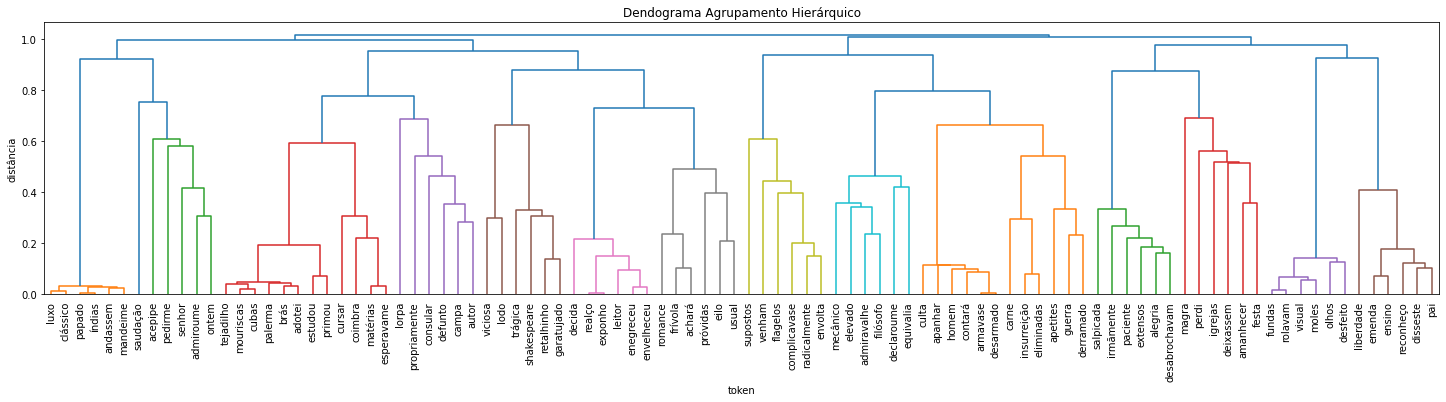

In [63]:
# Escolhe as palavras que serão usadas como referência para obter uma amostra
referenceWords = [
    'defunto', 'brás', 'romance', 'coimbra', 'flagelos', 'alegria', 'shakespeare', 'homem', 'luxo',
    'filósofo', 'festa', 'olhos', 'ontem', 'guerra', 'ensino', 'leitor'
]
visualizeDendogram(referenceWords, wordVecsBrasCubas, token2indexBrasCubas, index2tokenBrasCubas,
                   title = 'Dendograma Agrupamento Hierárquico Brás Cubas', 
                   ylabel = 'distância', xlabel = 'token')

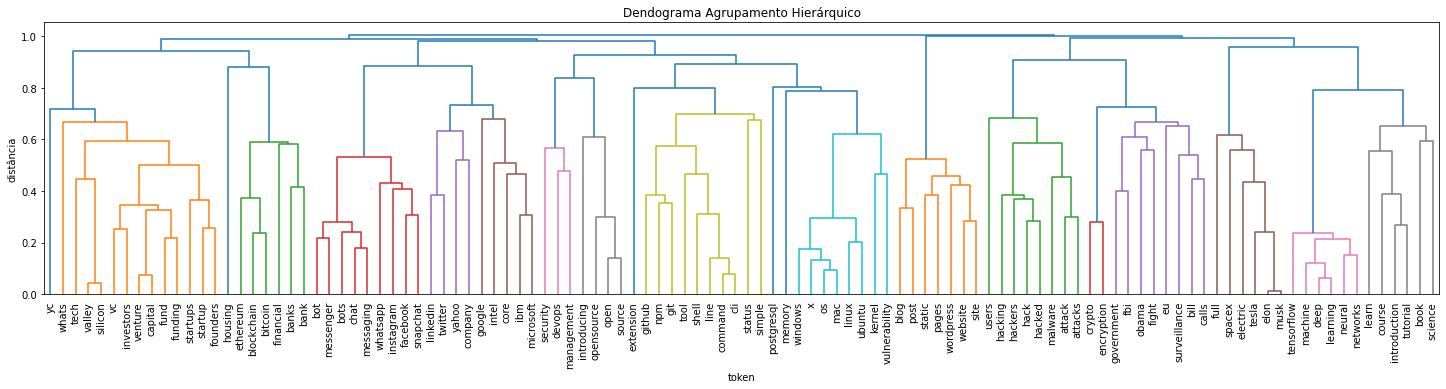

In [64]:
referenceWords = ['facebook', 'twitter', 'instagram', 'messenger', 'hack', 'security', 
          'deep', 'encryption', 'command', 'venture' , 'bitcoin', 'github', 'opensource',
          'linux', 'microsoft', 'tensorflow', 'whatsapp', 'kernel', 'bill', 'elon', 'silicon', 'course',
           'startup', 'blog']
visualizeDendogram(referenceWords, wordVecsHN, token2indexHN, index2tokenHN,
                   title = 'Dendograma Agrupamento Hierárquico Hard News',
                   ylabel = 'distância', xlabel = 'token')

### 11. Composição de Vetores

In [107]:
def getNearestWord(matrix, wordVec, index2token):
    # Cálculo da similidade (similaridade de vetores por cosseno)
    similarity = cosine_similarity(matrix, wordVec).flatten()
    sortedIndexes = np.argsort(-similarity)
    
    for index in sortedIndexes[:10]:
        print(index2token[index], similarity[index])
    
    
    return (index2token[index], similarity[index])

In [85]:
composition = wordVecsHN[token2indexHN['facebook']] + wordVecsHN[token2indexHN['images']]
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

images 0.7349638877603482
facebook 0.7349638877603482
instagram 0.6178229577281579
photos 0.5661414009542866
twitter 0.5481670513246248


('twitter', 0.5481670513246248)

In [91]:
composition = wordVecsHN[token2indexHN['facebook']] - wordVecsHN[token2indexHN['ads']]
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

chat 0.5021600803670023
facebook 0.5019745003998232
slack 0.4611275228968687
snapchat 0.4597930899750736
messenger 0.44733667107931463


('messenger', 0.44733667107931463)

In [92]:
composition = wordVecsHN[token2indexHN['machine']] + wordVecsHN[token2indexHN['learning']]
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

machine 0.9781464123256521
learning 0.978146412325652
deep 0.9107303704429375
neural 0.8329682653473313
tensorflow 0.7701316851618643


('tensorflow', 0.7701316851618643)

In [102]:
composition = wordVecsHN[token2indexHN['windows']] +  wordVecsHN[token2indexHN['open']] 
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

open 0.7336584766984728
windows 0.7336584766984727
source 0.6979564794544455
linux 0.640853431985693
os 0.6264732964065594


('os', 0.6264732964065594)

In [103]:
composition = wordVecsHN[token2indexHN['fbi']] +  wordVecsHN[token2indexHN['obama']] 
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

obama 0.8596812247773494
fbi 0.8596812247773493
nsa 0.7094734792965574
snowden 0.6651042000962033
isis 0.5459378249771826


('isis', 0.5459378249771826)

In [104]:
composition = wordVecsHN[token2indexHN['spacex']] -  wordVecsHN[token2indexHN['elon']] 
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

rocket 0.5692131933815251
spacex 0.44867900908580155
flight 0.420953646973773
launch 0.41591052021890984
first 0.4141582674401146


('first', 0.4141582674401146)

In [109]:
composition = wordVecsHN[token2indexHN['company']] +  wordVecsHN[token2indexHN['iphone']]
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

iphone 0.7204752256471292
company 0.720475225647129
apple 0.6854693037109383
samsung 0.5895844455434436
apples 0.47031419082988196
sales 0.4666886286089246
fbi 0.46557170407938653
model 0.43213309304135006
event 0.42229678129371356
wireless 0.4140587022130082


('wireless', 0.4140587022130082)

In [110]:
composition = wordVecsHN[token2indexHN['html']] +  wordVecsHN[token2indexHN['css']]
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

html 0.9455515802667784
css 0.9455515802667782
javascript 0.693414785389735
react 0.6710683419079364
components 0.6439407318952739
generator 0.6266565658066717
editor 0.6044300136038571
plugin 0.5920971655858663
style 0.5702265366980899
ui 0.5474698451099583


('ui', 0.5474698451099583)

In [117]:
composition = wordVecsHN[token2indexHN['apple']] -  wordVecsHN[token2indexHN['steve']] +  wordVecsHN[token2indexHN['elon']]
getNearestWord(wordVecsHN, composition.reshape(1,-1), index2tokenHN)

apples 0.6441218193934289
apple 0.6386434939864155
elon 0.6269261816622035
tesla 0.5832571512305038
musk 0.5817753957826801
iphone 0.4700703805230217
samsung 0.46640328225298616
electric 0.436506949612381
solar 0.4206986400900926
model 0.4060169538285376


('model', 0.4060169538285376)